# Graph Theory project

**Group 3**: <small>Halil Özgür, Valentin L'Homel, Selim Eren Eryılmaz</small>

For this project, we have decided to study the relationship between the degree and the betweeness centrality on public transportation networks. Actually, we hypothesised that the stations which where may transit most people were the ones with the highest number of different available transportation.

#### Code initialization

In [209]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import KDTree
from geopy import distance

### Graphs

In order to verify our hypothesis, we used the public transportation networks of Istanbul, divided by Eurpoean and Asian side.

The European side is composed of 6741 stations, with 38465 connections in-between. The Asian side, on the other hand, is composed of 5957 stations with 34553 connections.

Considering that some stations may have different names despite being the sames, we automatically reduced the number of stations, and by extension links, according to their locations by merging them together. Therefore, the graphs used for the upcoming calculations actually holds less nodes and edges, but the organization of the network should be the same.

In [210]:
hats = pd.read_csv("data_gathering/csv_files/hat_all.csv", index_col=0)
guzergahs = pd.read_csv("data_gathering/csv_files/guzergah_all.csv", index_col=0)

# Normally 25 eu 14 asia but iett has some stops in Kocaeli's districts.
europe_districts = ["ARNAVUTKÖY", "AVCILAR", "BAGCILAR", "BAHÇELIEVLER", "BAKIRKÖY", 
                    "BASAKSEHIR", "BAYRAMPASA", "BESIKTAS", "BEYLIKDÜZÜ", "BEYOGLU", 
                    "BÜYÜKÇEKMECE", "ESENLER", "ESENYURT", "EYÜPSULTAN", "FATIH", 
                    "GAZIOSMANPASA", "GÜNGÖREN", "KAGITHANE", "KÜÇÜKÇEKMECE", "SARIYER",
                    "SILIVRI", "SISLI", "SULTANGAZI", "ZEYTINBURNU", "ÇATALCA"]
guzergahs["SIDE"] = "ASIA"
guzergahs.loc[guzergahs["ILCEADI"].str.upper().isin(europe_districts), "SIDE"] = "EUROPE"

duraks = guzergahs[['DURAKKODU','DURAKADI','XKOORDINATI','YKOORDINATI','SIDE']].drop_duplicates()

In [211]:
pos = {kod:(x, y) for kod, x, y in zip(duraks.DURAKKODU, duraks.XKOORDINATI, duraks.YKOORDINATI)}
drk = {kod:durak for kod, durak in zip(duraks.DURAKKODU, duraks.DURAKADI)}
side = {kod:side for kod, side in zip(duraks.DURAKKODU, duraks.SIDE)}

G = nx.Graph()
for hat in hats[hats.HAT_DURUMU==1].HAT_KODU.to_numpy():
    yol = guzergahs[(guzergahs.HATKODU==hat) & (guzergahs.YON=='D')]
    yol = [o[1] for o in sorted(zip(yol.SIRANO, yol.DURAKKODU))]
    if len(yol) > 1:
        G.add_edges_from(zip(yol[:-1], yol[1:]))
    
    yol = guzergahs[(guzergahs.HATKODU==hat) & (guzergahs.YON=='G')]
    yol = [o[1] for o in sorted(zip(yol.SIRANO, yol.DURAKKODU))]
    if len(yol) > 1:
        G.add_edges_from(zip(yol[:-1], yol[1:]))

In [212]:
def create_contract():
    nodepos = np.asarray([np.asarray(pos[node]) for node in G.nodes])
    tree = KDTree(nodepos)
    contract = []
    for i, node in enumerate(G.nodes):
        close = tree.query([nodepos[i]], k=2)[1][0][1]
        if drk[node] == drk[list(G.nodes)[close]]:
            pair = sorted((node, list(G.nodes)[close]))
            if pair not in contract:
                contract.append(pair)

    #print("Node Count: ",len(G.nodes), "\tContract Length: ",len(contract))
    return np.array(contract)

In [213]:
def merge_contract_list(contract):
    contract_count = 0
    for i,(u,v) in enumerate(contract):
        contract_slice = contract[i:]
        contract_mask = (contract_slice[:,0]==v)
        contracted = contract_slice[contract_mask]
        if len(contracted>0):
            # print(contracted)
            # print(i, u, v)
            contract_count += 1
            contract_slice[contract_mask,0] = u
            contract[i:] = contract_slice
    #print("Number of contract hits: ", contract_count)
    return contract

In [214]:
def merge_nodes(contract):
    for u,v in contract:
        if u in G.nodes and v in G.nodes:
            nx.algorithms.minors.contracted_nodes(G, u, v, copy=False)
    #print("Node Count After Merge: ", len(G.nodes))

In [215]:
while(True):
    #print("Creating contract")
    contract = create_contract()
    contract_len = len(contract)
    if(contract_len == 0):
        break
    while(True):
        #print("Merging contract")
        contract_merged = merge_contract_list(contract.copy())
        if(np.all(contract == contract_merged)):
            break 
        else:
            contract = contract_merged
    #print("Merging nodes")
    merge_nodes(contract)
    #print("Removing Self loops")
    #print("Before Edge: ", len(G.edges))
    G.remove_edges_from(nx.selfloop_edges(G))
    #print("After Edge: ", len(G.edges),"\n")

In [216]:
#Create subgraphs
G_ASIA = G.subgraph([node for node in G.nodes() if side[node] == 'ASIA'])
G_EU = G.subgraph([node for node in G.nodes() if side[node] == 'EUROPE'])

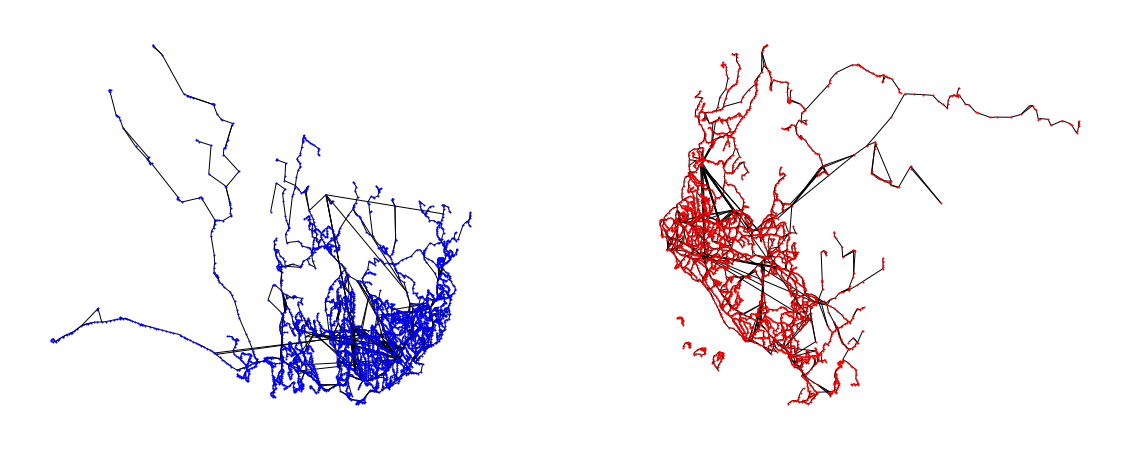

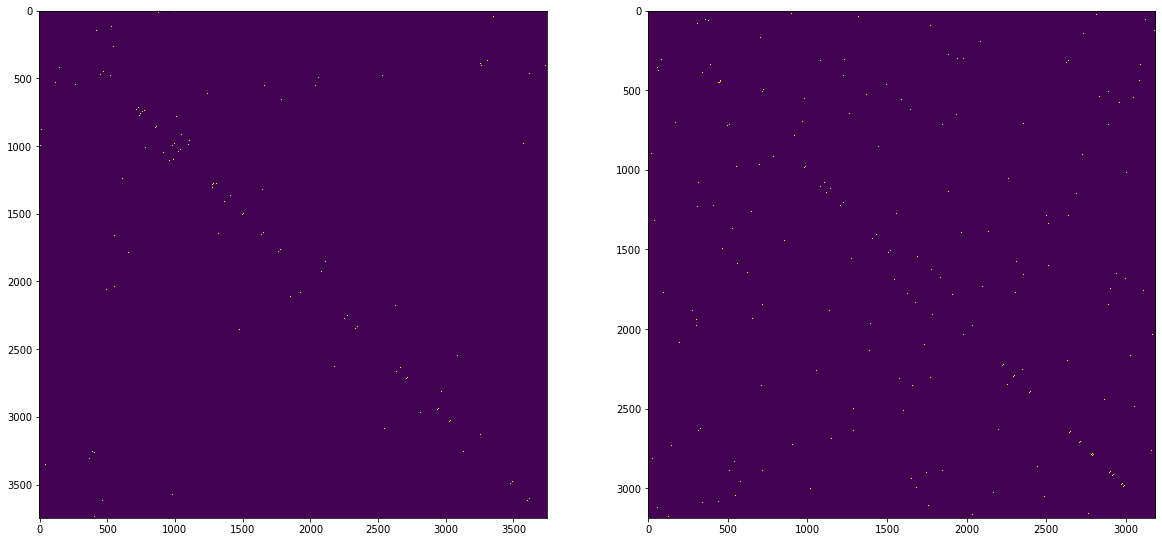

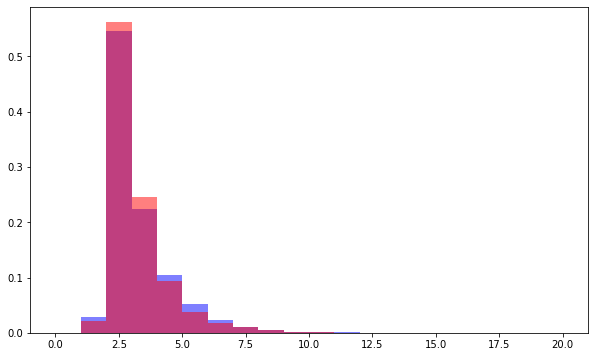

In [217]:
#fig, ax = plt.subplots(1, 1, figsize=(20,10))
#node_color = ["b" if G.nodes[node]["side"]=="EUROPE" else "r" for node in G.nodes]
#nx.draw(G, pos=pos, node_size=1, node_color = node_color, ax=ax)
#plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
nx.draw(G_EU,   pos=pos, node_size=1, node_color='blue', ax=ax1)
nx.draw(G_ASIA, pos=pos, node_size=1, node_color='red', ax=ax2)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
plt.sca(ax1)
plt.imshow(nx.to_numpy_array(G_EU),   interpolation='nearest')
plt.sca(ax2)
plt.imshow(nx.to_numpy_array(G_ASIA), interpolation='nearest')
plt.show()

degrees_EU = [d for _,d in G_EU.degree()]
degrees_ASIA = [d for _,d in G_ASIA.degree()]
plt.figure(figsize=(10,6))
plt.hist(degrees_EU,   weights=[1/len(G_EU)]*len(G_EU),     bins=range(max(degrees_EU+degrees_ASIA)), alpha=0.5, color='blue')
plt.hist(degrees_ASIA, weights=[1/len(G_ASIA)]*len(G_ASIA), bins=range(max(degrees_EU+degrees_ASIA)), alpha=0.5, color='red')
plt.show()

### Degree and Betweenness Centrality

As explained on the introduction, we will analyse both the degree and betweenness centrality of our graphs.

#### Degree

The degree corresponds to the number of link a node have to other links. A link with yourself can also be considered, event if we have exclude them on our case.

In our case, the degree of a node of our networks corresponds to the number of public transportations which arrive or leave from a given station. Most of the time, this is actually equal to the double of the number of different transportations passing through this station; with the only exception of the terminus of these transportations.

#### Betweenness Centrality

The betweenness centrality is a measure assign to a node representing the number of shortests path between any two node that pass through this node. The betweenness centrality is usually calculated as follow:

$$ \sum_{s,t,v \in N_G}{\frac{\sigma_{st}^v}{\sigma_{st}}} $$

In this equation, $N_G$ represents the set of nodes of the graph $G$, $\sigma_{st}$ represents the number of shortest path between the nodes $s$ and $t$, while $\sigma_{st}^v$ also represents the number of shortest path between the nodes $s$ and $t$, but which are also passing through the node $v$. Note that whenever $v$ is one of $s$ or $t$, $\sigma_{st}^v$ is considered $0$.

In our case, the betweenness centrality will show whether a station is more likely to be visited by a passenger transiting through two points, if it were to move optimally. The highest is the betweenness centrality, the more passengers are likely to be present at this station.

### Calculations

In [218]:
for start,end in G.edges():
    G[start][end]['weight'] = 1 / distance.geodesic(pos[start], pos[end]).kilometers

In [219]:
# Initially took me 13 min
degrees = G.degree()
#betweenness = nx.betweenness_centrality(G, weight='weight')
import json
betweenness = json.load(open('graph_data/betweenness.json'))

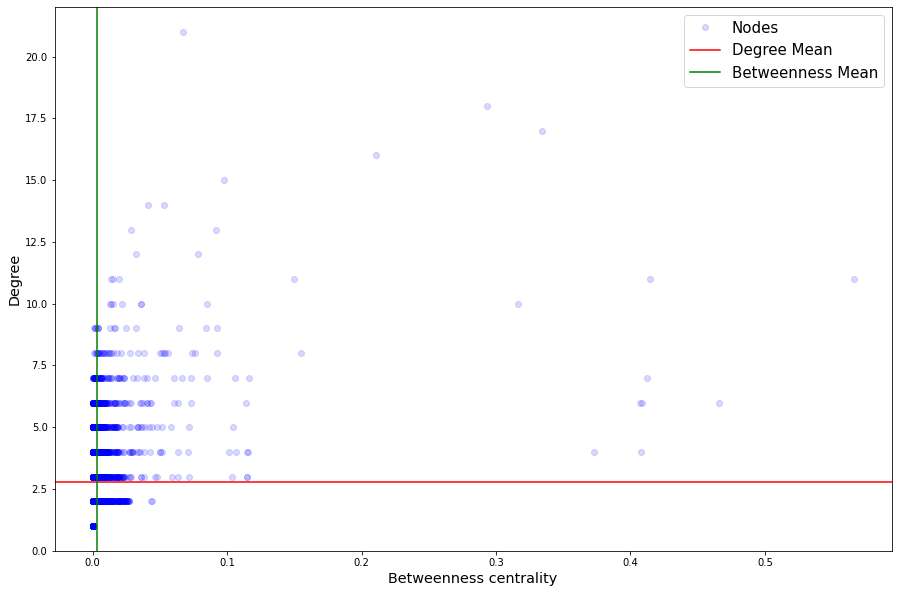

In [220]:
plt.subplots(1, 1, figsize=(15,10))
btw_list = list(betweeness.values())
degree_list = [degree for code,degree in degrees]
plt.plot(btw_list, degree_list, 'ob', alpha=0.15, label="Nodes")
plt.axhline(np.mean(degree_list), c="r", label="Degree Mean")
plt.axvline(np.mean(btw_list), c="g", label="Betweenness Mean")

plt.ylabel(r'Degree', size='x-large')
plt.xlabel(r'Betweenness centrality', size='x-large')
plt.legend(prop={'size': 15})
plt.show()
